# Examples

This notebook shows a simple example of how to use `tempstruc` to test for oscillations in a time-series.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

import tempstruc

np.random.seed(0)  # Set the random seed for reproducibility

First, let's simulate some data as a random walk with an added oscillation. We'll include multiple observations per time-point, with a bit of random noise at each time point.

In this simulation, the outcome variable is continuous (like reaction time), but you could also use a binary outcome variable (like accuracy).

In [2]:
n_timepoints = 52
n_obs_per_timepoint = 20
f_sample = 60.0
osc_freq = 8.0
osc_amp = 3.0

# Simulate an oscillation plus random walk noise
t = np.arange(n_timepoints) / f_sample
x = np.cumsum(np.random.normal(size=n_timepoints))
osc = osc_amp * np.sin(2 * np.pi * osc_freq * t)
x = x + osc

# Make multiple observations for each timepoint
t = np.repeat(t, n_obs_per_timepoint)  # The time-stamp for each trial
x = np.repeat(x, n_obs_per_timepoint)  # The outcome variable for each trial
x += np.random.normal(size=x.shape)  # Add some white noise

The AR surrogate and robust est. methods require a time-series that has already been averaged for each time-point. In contrast, the time-shuffled methods (LF2012 and FSK2013) require the raw data, with individual trial outcomes and time-stamps.

In [3]:
# Average over each timepoint
df = pd.DataFrame({'x': x, 't': t})
df_avg = (df
          .groupby('t', as_index=False)
          .agg(np.mean))
x_avg = df_avg['x'].to_numpy()
t_avg = df_avg['t'].to_numpy()

Text(0, 0.5, 'Amplitude')

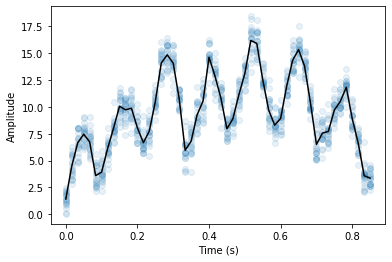

In [4]:
plt.plot(t, x, 'o', alpha=0.1)
plt.plot(t_avg, x_avg, '-k')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

In [5]:
def plot_results(res):
    plt.plot(res['f'], res['y_emp'],
             label='Spectrum')
    if 'y_perm' in res:
        plt.plot(res['f'],
                 np.percentile(res['y_perm'], 95, axis=0),
                 '--k',
                 label='95% CI')
    signif = res['p_corr'] < 0.05
    plt.plot(res['f'][signif], res['y_emp'][signif],
             '*r',
             label='p < .05')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(1, 15)
    plt.legend()    

Text(0.5, 1.0, 'AR Surrogate')

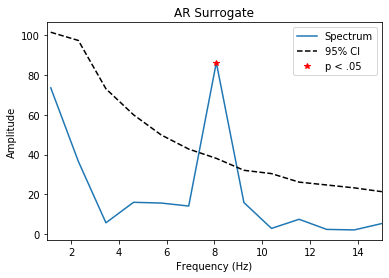

In [6]:
res = tempstruc.ar_surr(x_avg, f_sample, k_perm=500)
plot_results(res)
plt.title('AR Surrogate')

Text(0.5, 1.0, 'Robust estimate')

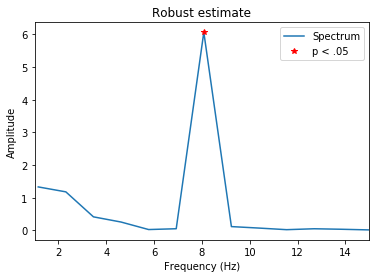

In [7]:
res = tempstruc.robust_est(x_avg, f_sample)
plot_results(res)
plt.title('Robust estimate')

Text(0.5, 1.0, 'LF2012')

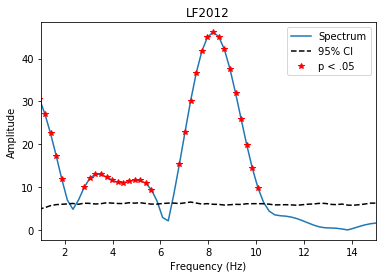

In [8]:
res = tempstruc.lf2012(x, t, f_sample, k_perm=500)
plot_results(res)
plt.title('LF2012')

Text(0.5, 1.0, 'FSK2013')

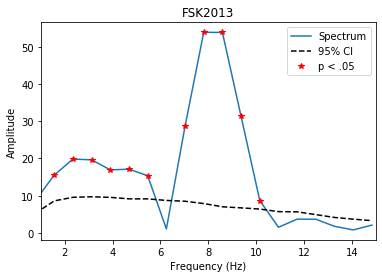

In [9]:
res = tempstruc.fsk2013(x, t, k_perm=500, f_max=15.0)
plot_results(res)
plt.title('FSK2013')